# Experimet s využitím transfer learningu

## Knižnice

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from pathlib import Path

#Load images https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb?hl=sk#scrollTo=ZJ20R66fzktl
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt


import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import PIL

## Dáta
Tento experiment sme vykonávali v prostredí Google Colab. Pre jednoduchší prístup k dátam s ktorými sme experiment vykonávali sme si namapovali google drive priečinok projektu. 

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Cesta k datasetu na drive 
path = Path('/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/fiit_stu_ns_jurkacek_pejchalova/data/raw/DATASET/')

#Cesta k natrénovanému modelu
model_path = Path('/content/drive/My Drive/STU_FIIT/inzinier/3_semester/ns/projekt/eTrash.h5')

## Distribúcia klasifikovaných tried v datasete

In [5]:
train_r = len(list(path.glob('TRAIN/R/*.jpg')))
print(f'train R: {train_r}')

train_o = len(list(path.glob('TRAIN/O/*.jpg')))
print(f'train O: {train_o}')

test_r = len(list(path.glob('TEST/R/*.jpg')))
print(f'test R: {test_r}')

test_o = len(list(path.glob('TEST/O/*.jpg')))
print(f'test O: {test_o}')

train R: 9999
train O: 12565
test R: 1112
test O: 1401


## Využitie existujúcej ResNet50 architektúra
Stiahli sme si ResNet50 architektúru aj s váhami, ktoré boli natrénované na imagenet datasete.

In [0]:
from tensorflow.keras.applications import ResNet50
res = ResNet50(input_shape = (224, 224, 3), include_top = True, weights = 'imagenet')
res.summary()

102973440/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

ResNet50 sme upravili na klasifikáciu do 2 tried 'O'(Organické) a 'R'(Recyklovateľné). Výslednú architektúru použítú na trénovanie sme znázornili na obrázku.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,893,482
Trainable params: 25,840,362
Non-trainable params: 53,120
_________________________________________________________________


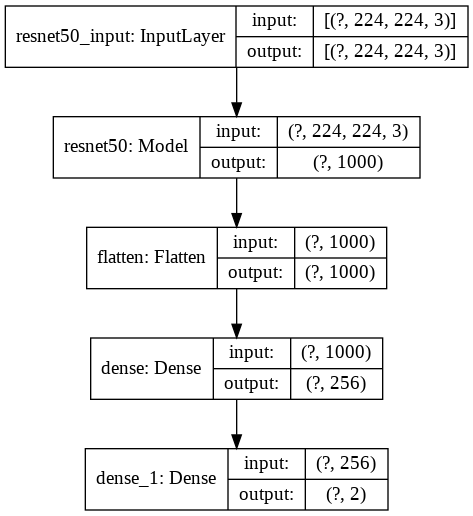

In [0]:
model = tf.keras.models.Sequential()
model.add(res)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Trénovacia a testovacia sada

In [0]:
train_gen = ImageDataGenerator(rescale=1./224.)
test_gen = ImageDataGenerator(rescale=1./224.)

train_dir = path /'TRAIN'
test_dir = path /'TEST'

train_generator = train_gen.flow_from_directory(train_dir, batch_size = 32, target_size = (224, 224), class_mode = 'binary')
test_generator = test_gen.flow_from_directory(test_dir, batch_size = 32, target_size = (224, 224), class_mode = 'binary')

print(train_generator)
print(test_generator)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


Vykonali sme trénovanie a model uložili

In [0]:
#hist = model.fit_generator(train_generator, epochs = 15, validation_data = test_generator)
#model.save('eTrash.h5')

## Načítanie natrénovaného modelu

In [6]:
resNet_model = tf.keras.models.load_model(model_path)
resNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,893,482
Trainable params: 25,840,362
Non-trainable params: 53,120
_________________________________________________________________


## Vyhodnotenie modelu na testovacej sade
Tento model dosiahol podozrivo nízku úspešnosť 55.19%. Tento experiment v ďalšej fáze zopakujeme aby sme mohli potvrdiť túto hodnotu.

In [10]:
test_dir = path /'TEST'
test_gen = ImageDataGenerator(rescale=1./224.)
test_generator = test_gen.flow_from_directory(test_dir, batch_size = 32, target_size = (224, 224), class_mode = 'binary')
loss, acc = resNet_model.evaluate_generator(test_generator)
print('Restored resNet model, accuracy: {:5.2f}%'.format(100*acc))

Found 2513 images belonging to 2 classes.
Restored resNet model, accuracy: 55.19%


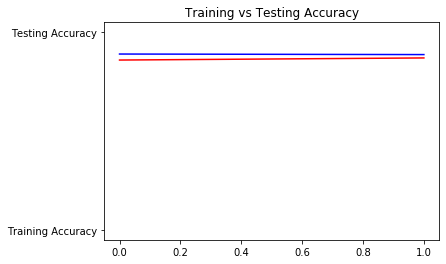

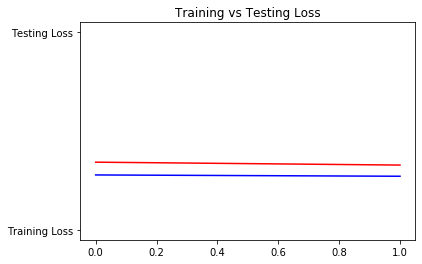

In [0]:
%matplotlib inline
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Testing Accuracy")
plt.title('Training vs Testing Accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Testing Loss")
plt.title('Training vs Testing Loss')
plt.show()